Counting programming language mentions in astronomy papers
==========================================================

"2016 Edition" Author: Juan Nunez-Iglesias.

Adapted from code [written by](https://nbviewer.jupyter.org/github/astrofrog/mining_acknowledgments/blob/master/Mining%20acknowledgments%20in%20ADS.ipynb)
[Thomas P. Robitaille](http://mpia.de/~robitaille/)
and
[updated by](https://nbviewer.jupyter.org/github/ChrisBeaumont/adass_proceedings/blob/master/Mining%20acknowledgments%20in%20ADS.ipynb)
[Chris Beaumont](https://chrisbeaumont.org/).

This work is licensed under a [Creative Commons Attribution-NonCommercial-ShareAlike 3.0 Unported](http://creativecommons.org/licenses/by-nc-sa/3.0/deed.en_US) License.

![license](http://i.creativecommons.org/l/by-nc-sa/3.0/88x31.png)

A couple of years ago I came across [this tweet](https://twitter.com/BeaumontChris/status/517412133181865984) by Chris Beaumont, showing Python overtaking Matlab and rapidly gaining ground on IDL in astronomy.

I've referred to that plot a couple of times in the past, but now that I wanted to use it in a talk, I thought it was time to update it. Hence, this notebook.

First, let's import everything we need. You can install it all using either conda or pip.

In [1]:
%matplotlib inline
import os

import brewer2mpl
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from prettyplotlib.utils import remove_chartjunk
from datetime import datetime, date

Let's set some nice Matplotlib defaults. Note that there is a deprecation warning when setting the default color cycle, but I can't be bothered tracking down the fix. (It is not the simple replacement suggested by the deprecation message.)

In [2]:
mpl.rcParams['axes.color_cycle'] = brewer2mpl.get_map('Paired', 'qualitative', 12).mpl_colors[1::2] + [(0.94, 0.01, 0.50)]
mpl.rcParams['figure.figsize'] = (9,6)
mpl.rcParams['font.size'] = 14

/Users/nuneziglesiasj/anaconda/envs/ana3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Next, we import the [`ads` Python library](https://pypi.python.org/pypi/ads), which simplifies queries to the [Astrophysics Data System](https://ui.adsabs.harvard.edu). (The original notebooks used `requests` to create direct JSON queries, but the API appears to have changed in the meantime. I hope that using the `ads` library, someone else will take care of keeping the API queries up to date.)

To run this notebook, **you need to get a free API key** to allow queries to the ADS system. Create an account at [ADS](https://ui.adsabs.harvard.edu), log in, and then look for "Generate a new key" under your user profile.

Then, copy that key into a file called `.ads/dev_key` in your home directory. (You can also pass it as a string using the `token=<my_key>` keyword argument to `SearchQuery`, below)

In [3]:
import ads as ads

The ADS system has a daily limit to the number of queries you can perform with a given key (I think 5,000, as of this writing). So that you're not wasting queries while you're developing, you can use the `ads.sandbox` package that will return mock results to your queries. Uncomment the following cell to use the sandbox instead of the real API.

In [4]:
# Uncomment the following line to use the sandbox
#import ads.sandbox as ads

Next, we write a function that will count up how many results an individual query and year return, as well as a function to combine related queries (such as 'MATLAB' and 'Matlab').

In [5]:
def yearly_counts(query='', years=(2000, 2017),
                  acknowledgements=False):
    if acknowledgements:
        query = 'ack:' + query
    modifiers = ' '.join(['year:%i'])
    full_query = ' '.join([query, modifiers])
    filter_query = ['database:astronomy',
                    'property:refereed']
    results = []
    for year in range(*years):
        papers = ads.SearchQuery(q=full_query % year,
                                 fq=filter_query)
        papers.execute()
        count = int(papers.response.numFound)
        total_papers = ads.SearchQuery(q=modifiers % year)
        total_papers.execute()
        total_count = int(total_papers.response.numFound)
        now = datetime.now().timetuple()
        if year == now.tm_year:
            days_in_year = date(year, 12, 31).timetuple().tm_yday
            count *= days_in_year / now.tm_yday
            total_count *= days_in_year / now.tm_yday
        results.append([year, count, total_count])
    return np.array(results)

def combine_results(res):
    combined = res[0]
    for r in res[1:]:
        combined[:, 1:] += r[:, 1:]
    return combined

Finally, create a dictionary mapping languages to queries. I've left some of the original queries commented out, but you can uncomment them if you care about those languages in astronomy.

As a side note, a simple measure of how annoying a language's name is is given by the number of queries necessary to find its mentions.

In [6]:
languages = {
    'IDL': ['IDL'], 
    'Python': ['Python'], 
    'Matlab': ['MATLAB', 'Matlab'], 
#    'Fortran': ['Fortran', 'FORTRAN'], 
#    'Java': ['Java'],
#    'C': ['C programming language', 'C language',
#          'C code', 'C library', 'C module'],
#    'R': ['R programming language', 'R language',
#          'R code', 'R library', 'R module'],
}

The next cell runs the queries. Don't waste those API hits!

In [7]:
results = {name: combine_results([yearly_counts(query)
                                  for query in queries])
           for name, queries in languages.items()}

Finally, define a function to plot the results:

In [8]:
def trendlines(queries, norm=False):
    for q in queries:
        counts = queries[q]
        x = counts[:, 0]
        y = np.copy(counts[:, 1])
        if norm:
            y /= counts[:, 2]
        plt.plot(x, y * 100, label=q, lw=4, alpha=0.8)
    plt.xlim(np.min(x), np.max(x))
    plt.xlabel('Year')
    plt.ylabel('Percent of Refereed\nPublications Mentioning')
    plt.legend(loc='upper left', frameon=False)
    remove_chartjunk(plt.gca(), ['top', 'right'])    

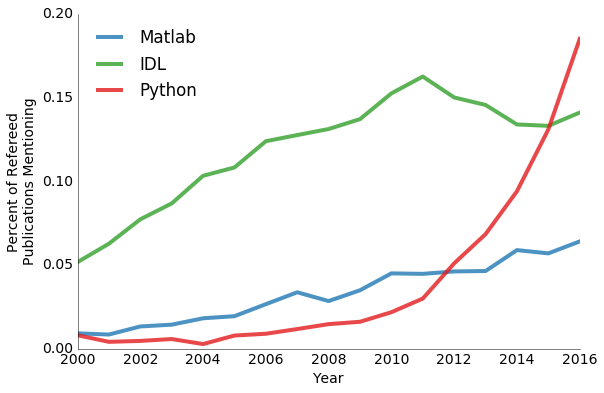

In [9]:
trendlines(results, norm=True)
plt.savefig('/Users/nuneziglesiasj/Desktop/python-vs-matlab-vs-IDL-in-astro.pdf')

There you have it: some time in early 2015, Python overtook IDL as the most mentioned (and probably the most used) programming language in astronomy!